In [1]:
%matplotlib widget

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import numpy as np

In [3]:
week_days_path = "./data/paris_weekdays.csv"
week_ends_path = "./data/paris_weekends.csv"

paris_weekdays = pd.read_csv(week_days_path, index_col=0)
paris_weekends = pd.read_csv(week_ends_path, index_col=0)

paris_weekdays['is_weekend'] = 0
paris_weekends['is_weekend'] = 1

paris_all = pd.concat([paris_weekdays, paris_weekends], ignore_index=True)

In [4]:
selected_columns = [
    "realSum", "dist", "metro_dist", "guest_satisfaction_overall", "attr_index_norm", "rest_index_norm"
]

In [5]:
paris_all_clean = paris_all
paris_all_std = paris_all_clean

In [6]:
# def remove_outliers(data, columns):
#     filtered_data = data.copy()
#     outlier_mask = pd.Series([True] * len(filtered_data))

#     for col in columns:
#         Q1 = filtered_data[col].quantile(0.25)
#         Q3 = filtered_data[col].quantile(0.75)
#         IQR = Q3 - Q1
#         lower_bound = Q1 - 3 * IQR
#         upper_bound = Q3 + 3 * IQR
#         outlier_mask &= (filtered_data[col] >= lower_bound) & (filtered_data[col] <= upper_bound)

#     filtered_data = filtered_data[outlier_mask]
#     removed_count = len(data) - len(filtered_data)
#     print(f"Removed {removed_count} outliers ({removed_count/len(data)*100:.2f}%)")
#     print(f"Remaining data: {len(filtered_data)} rows")

#     return filtered_data

# paris_all_clean = remove_outliers(paris_all, selected_columns)

In [7]:
# from sklearn.preprocessing import StandardScaler
# import matplotlib.pyplot as plt

# scaler = StandardScaler()
# paris_all_std = paris_all_clean.copy()
# paris_all_std[selected_columns] = scaler.fit_transform(paris_all_clean[selected_columns])

In [8]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def perform_clustering(data, n_clusters, selected_columns_):
    X = data[selected_columns_].copy()
        
    scaler = StandardScaler()
    # paris_all_std[selected_columns] = scaler.fit_transform(paris_all_clean[selected_columns])
    X = scaler.fit_transform(X)

    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X)

    return labels, kmeans, scaler

In [9]:
from sklearn.metrics import silhouette_score

def find_optimal_clusters(data, selected_columns_, max_clusters=10):
    """
    Find optimal number of clusters using elbow method and silhouette analysis
    """
    inertias = []
    silhouette_scores = []
    K_range = range(2, max_clusters + 1)
    
    X = data[selected_columns_].copy()
    
    for k in K_range:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        
        inertias.append(kmeans.inertia_)
        silhouette_scores.append(silhouette_score(X, labels))
        
    # Plot results
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    # Elbow Method
    ax1.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
    ax1.set_xlabel('Number of Clusters (k)', fontsize=12)
    ax1.set_ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
    ax1.set_title('Elbow Method', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    
    # Silhouette Method
    ax2.plot(K_range, silhouette_scores, 'ro-', linewidth=2, markersize=8)
    ax2.set_xlabel('Number of Clusters (k)', fontsize=12)
    ax2.set_ylabel('Silhouette Score', fontsize=12)
    ax2.set_title('Silhouette Analysis', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Find optimal k based on silhouette score
    optimal_k = K_range[silhouette_scores.index(max(silhouette_scores))]
    print(f"\nOptimal number of clusters based on silhouette score: {optimal_k}")
    print(f"Maximum silhouette score: {max(silhouette_scores):.4f}")
    
    return inertias, silhouette_scores, optimal_k

In [10]:
def visualize_clusters(data, cluster_column, title, columns):
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    unique_clusters = sorted(data[cluster_column].unique())

    for cluster in unique_clusters:
        cluster_data = data[data[cluster_column] == cluster]
        axes[0].scatter(
            cluster_data[columns[0]],
            cluster_data[columns[1]],
            label=f'Cluster {cluster}',
            alpha=0.6,
            edgecolors='white',
            linewidth=0.5
        )
    axes[0].set_xlabel(columns[0])
    axes[0].set_ylabel(columns[1])
    axes[0].set_title(f"{columns[0]} vs {columns[1]}")
    axes[0].legend()

    for cluster in unique_clusters:
        cluster_data = data[data[cluster_column] == cluster]
        axes[1].scatter(
            cluster_data[columns[0]],
            cluster_data[columns[2]],
            label=f'Cluster {cluster}',
            alpha=0.6,
            edgecolors='white',
            linewidth=0.5
        )
    axes[1].set_xlabel(columns[0])
    axes[1].set_ylabel(columns[2])
    axes[1].set_title(f"{columns[0]} vs {columns[2]}")
    axes[1].legend()

    for cluster in unique_clusters:
        cluster_data = data[data[cluster_column] == cluster]
        axes[2].scatter(
            cluster_data[columns[1]],
            cluster_data[columns[2]],
            label=f'Cluster {cluster}',
            alpha=0.6,
            edgecolors='white',
            linewidth=0.5
        )
    axes[2].set_xlabel(columns[1])
    axes[2].set_ylabel(columns[2])
    axes[2].set_title(f'{columns[1]} vs {columns[2]}')
    axes[2].legend()

    fig.suptitle(title, fontsize=14)
    plt.tight_layout()
    plt.show()

In [11]:
def visualize_clusters_3d(data, cluster_column, title, columns):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    unique_clusters = sorted(data[cluster_column].unique())

    for cluster in unique_clusters:
        cluster_data = data[data[cluster_column] == cluster]
        ax.scatter(
            cluster_data[columns[0]],
            cluster_data[columns[1]],
            cluster_data[columns[2]],
            label=f'Cluster {cluster}',
            alpha=0.6,
            s=30,
            edgecolors='white',
            linewidth=0.5
        )

    ax.set_xlabel(columns[0])
    ax.set_ylabel(columns[1])
    ax.set_zlabel(columns[2])
    ax.set_title(title)
    ax.legend(loc='upper left', framealpha=0.9)

    plt.tight_layout()
    plt.show()

In [12]:
columns_for_clustering = [
    "guest_satisfaction_overall",
    "rest_index_norm",
    "attr_index_norm"
]

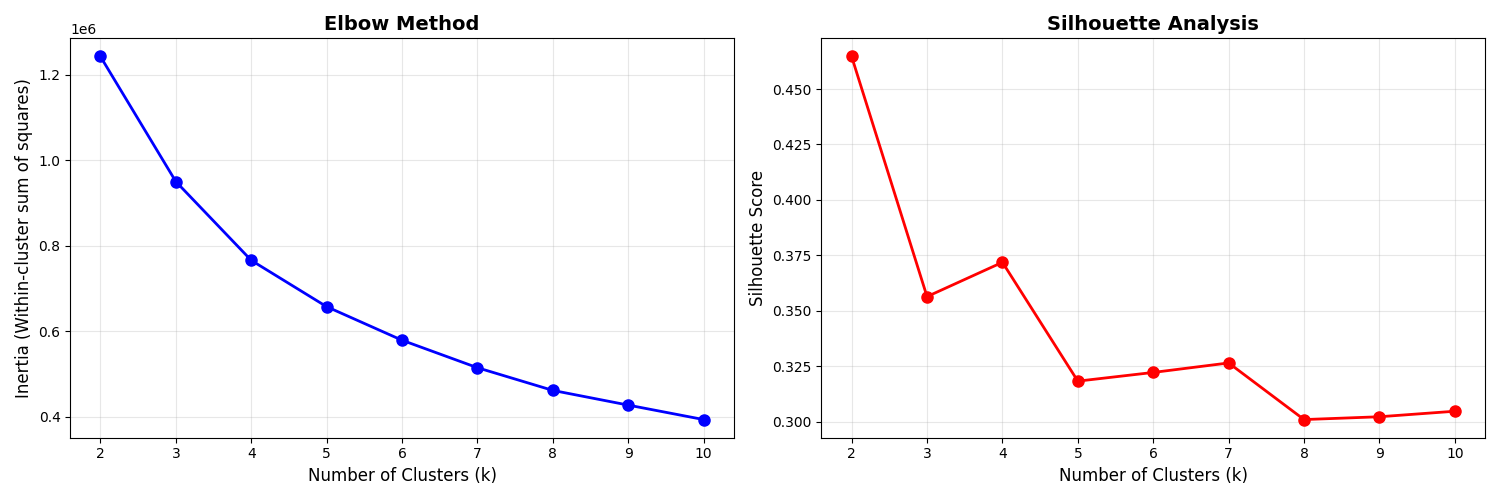


Optimal number of clusters based on silhouette score: 2
Maximum silhouette score: 0.4647


In [13]:
# Find optimal number of clusters
inertias, silhouette_scores, optimal_k = find_optimal_clusters(
    paris_all_clean, 
    columns_for_clustering, 
    max_clusters=10
)

In [14]:
def cluster_and_draw(data, cluster_num, columns_for_clustering_):
    inertias, silhouette_scores, optimal_k = find_optimal_clusters(
    data,
    columns_for_clustering_, 
    max_clusters=10
)

    labels_5, kmeans_5, scaler_5 = perform_clustering(data, cluster_num, columns_for_clustering_)
    cluster_label = f"cluster_{cluster_num}"
    data[cluster_label] = labels_5

    print(data.groupby(cluster_label)[['realSum', 'dist', 'guest_satisfaction_overall', 'is_weekend', 'host_is_superhost']].mean())
    print(f"\nCluster sizes: {data[cluster_label].value_counts().to_dict()}")

    visualize_clusters(data, cluster_label, f'K-Means Clustering with {cluster_num} Clusters', columns_for_clustering_)

    visualize_clusters_3d(data, cluster_label, f'K-Means Clustering with {cluster_num} Clusters', columns_for_clustering_)

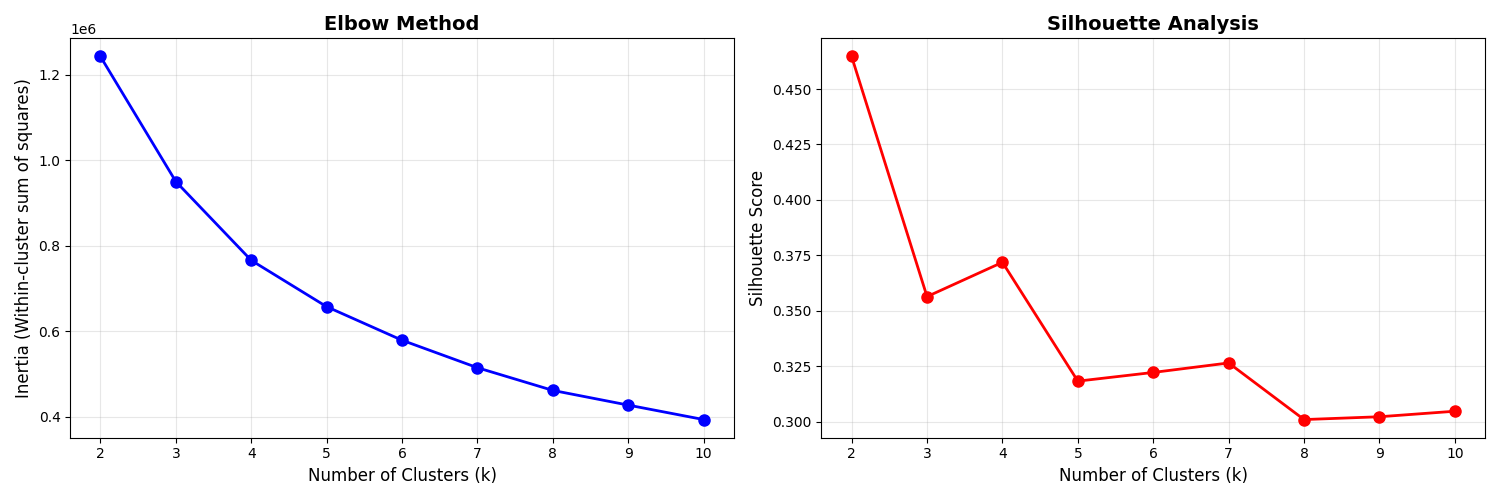


Optimal number of clusters based on silhouette score: 2
Maximum silhouette score: 0.4647
              realSum      dist  guest_satisfaction_overall  is_weekend  \
cluster_4                                                                 
0          529.188803  1.335299                   91.984242    0.421818   
1          325.201412  3.862204                   94.463506    0.597544   
2          355.147675  3.037196                   74.345528    0.532520   
3          443.720810  2.448249                   94.767898    0.485636   

           host_is_superhost  
cluster_4                     
0                   0.143030  
1                   0.155184  
2                   0.009485  
3                   0.164615  

Cluster sizes: {1: 2932, 3: 2193, 0: 825, 2: 738}


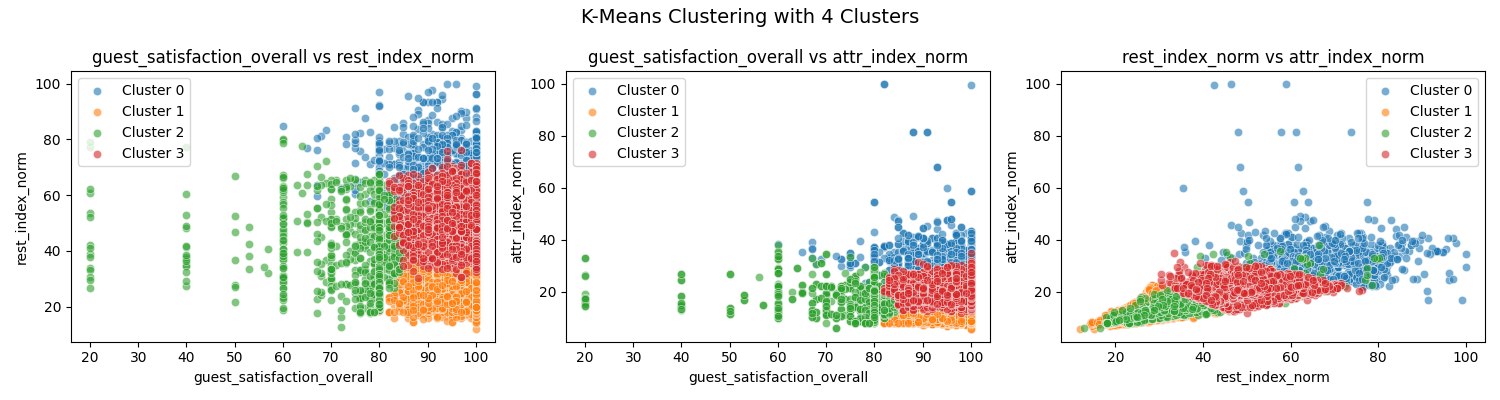

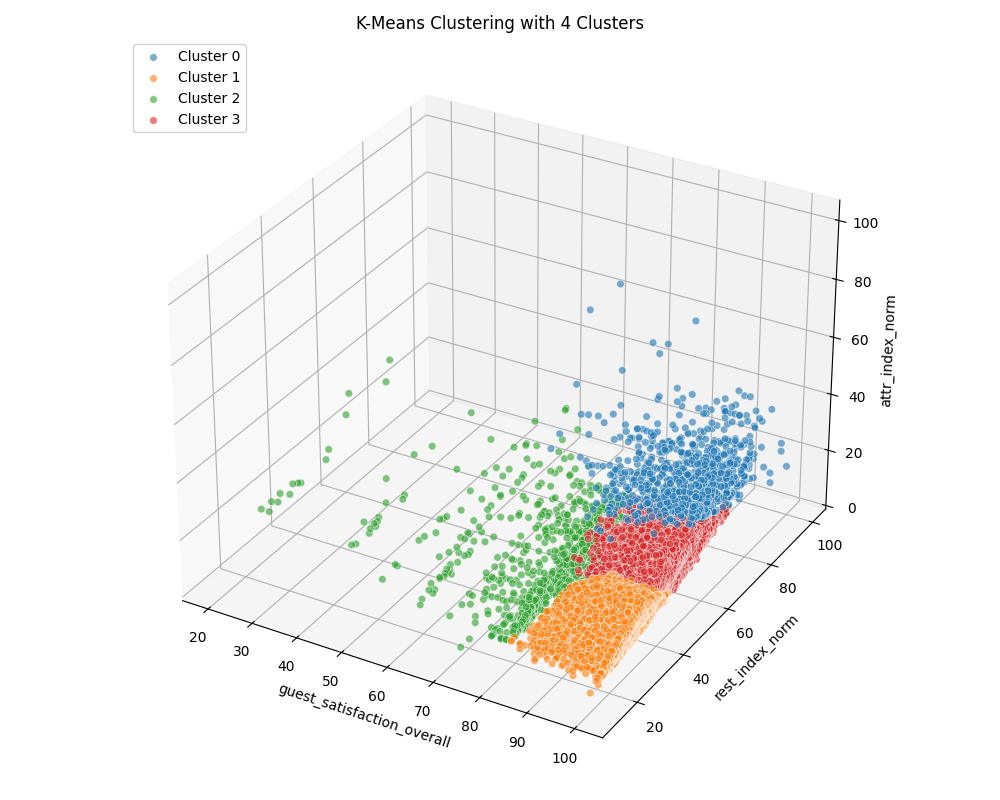

In [15]:
cluster_and_draw(paris_all_std, 4, columns_for_clustering)

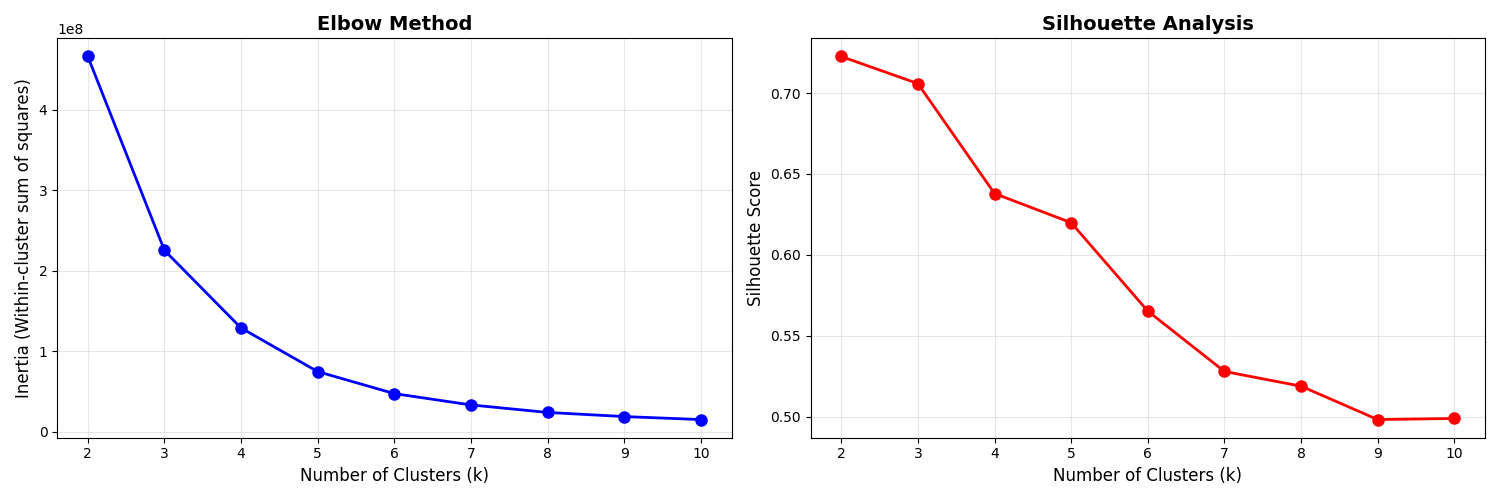


Optimal number of clusters based on silhouette score: 2
Maximum silhouette score: 0.7226
                realSum      dist  guest_satisfaction_overall  is_weekend  \
cluster_4                                                                   
0            309.859128  3.379375                   94.726833    0.535930   
1            347.191901  2.952940                   75.825849    0.516977   
2            616.191606  2.052696                   94.279098    0.530774   
3          16445.614689  4.602378                  100.000000    0.000000   

           host_is_superhost  
cluster_4                     
0                   0.156787  
1                   0.013143  
2                   0.171237  
3                   0.000000  

Cluster sizes: {0: 4133, 2: 1641, 1: 913, 3: 1}


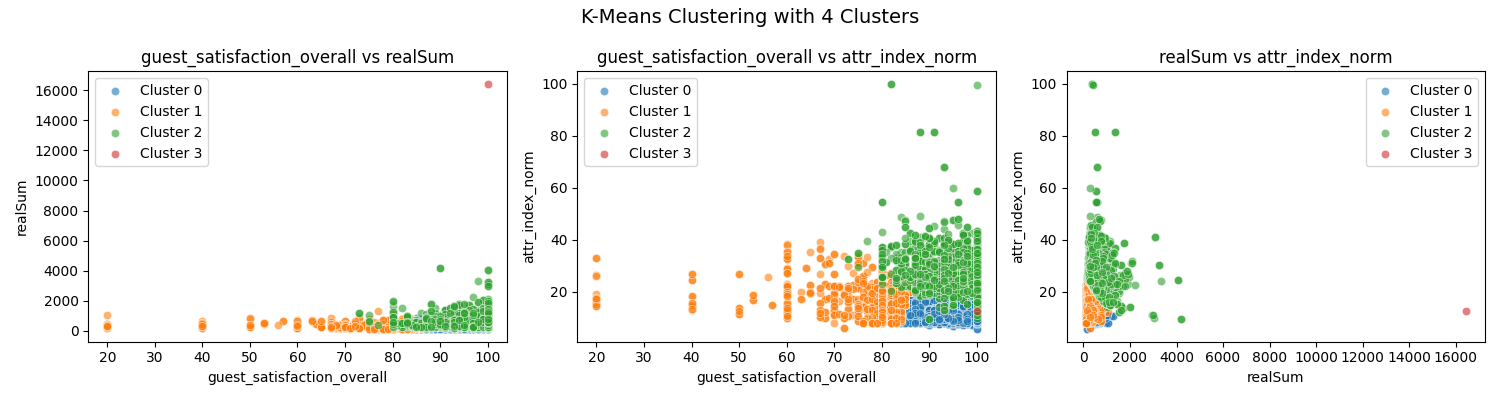

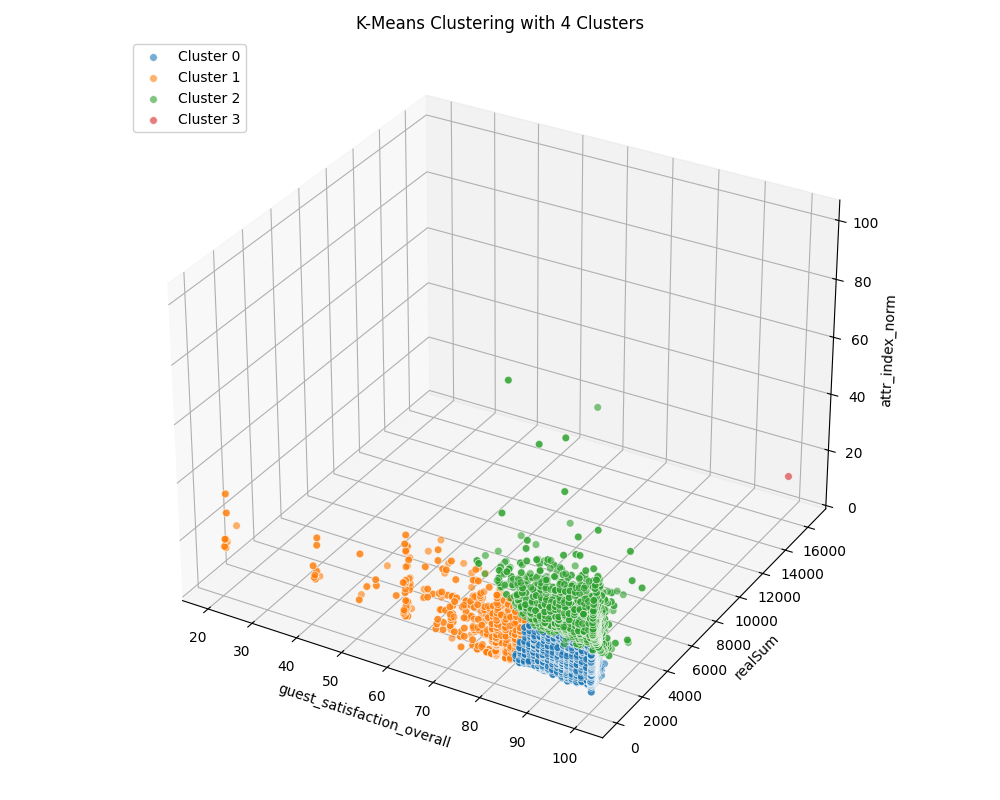

In [16]:
columns_for_clustering = [
    "guest_satisfaction_overall",
    "realSum",
    "attr_index_norm"
]

# paris_all_clean_v2 = paris_all_clean[paris_all_clean['realSum'] < 16000]
cluster_and_draw(paris_all_std, 4, columns_for_clustering)

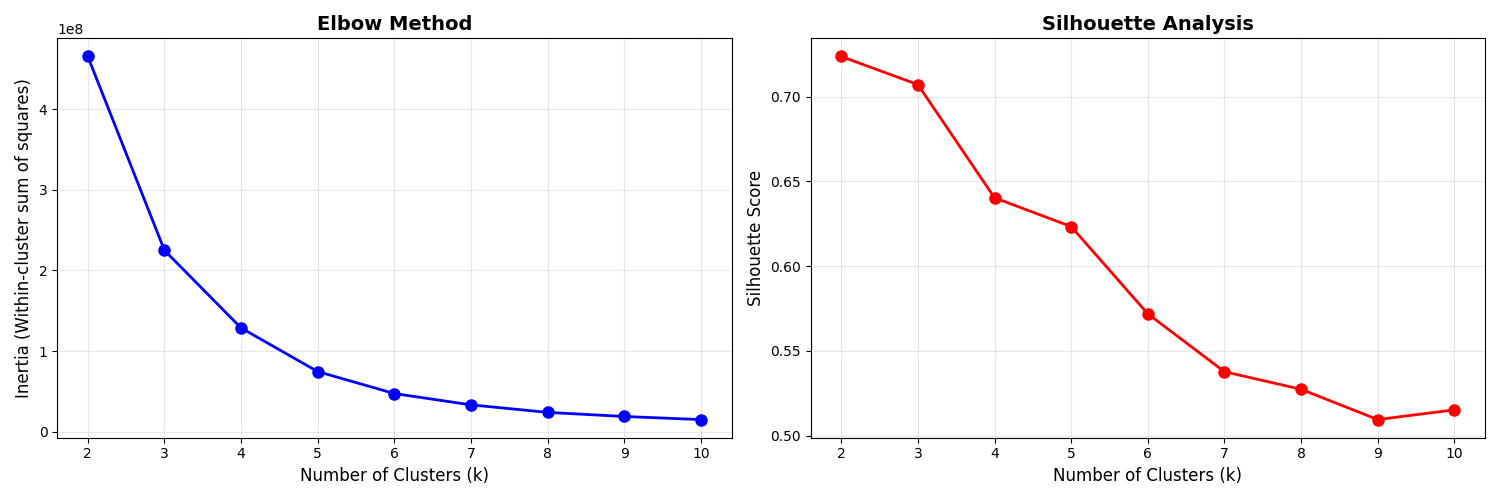


Optimal number of clusters based on silhouette score: 2
Maximum silhouette score: 0.7237
                realSum      dist  guest_satisfaction_overall  is_weekend  \
cluster_5                                                                   
0            359.926618  2.732819                   75.784116    0.514541   
1            335.352261  2.850789                   94.814746    0.540059   
2           1067.987526  2.489644                   95.349680    0.498934   
3          16445.614689  4.602378                  100.000000    0.000000   
4            335.817114  3.644076                   93.655392    0.532865   

           host_is_superhost  
cluster_5                     
0                   0.011186  
1                   0.166090  
2                   0.174840  
3                   0.000000  
4                   0.143586  

Cluster sizes: {1: 3757, 4: 1567, 0: 894, 2: 469, 3: 1}


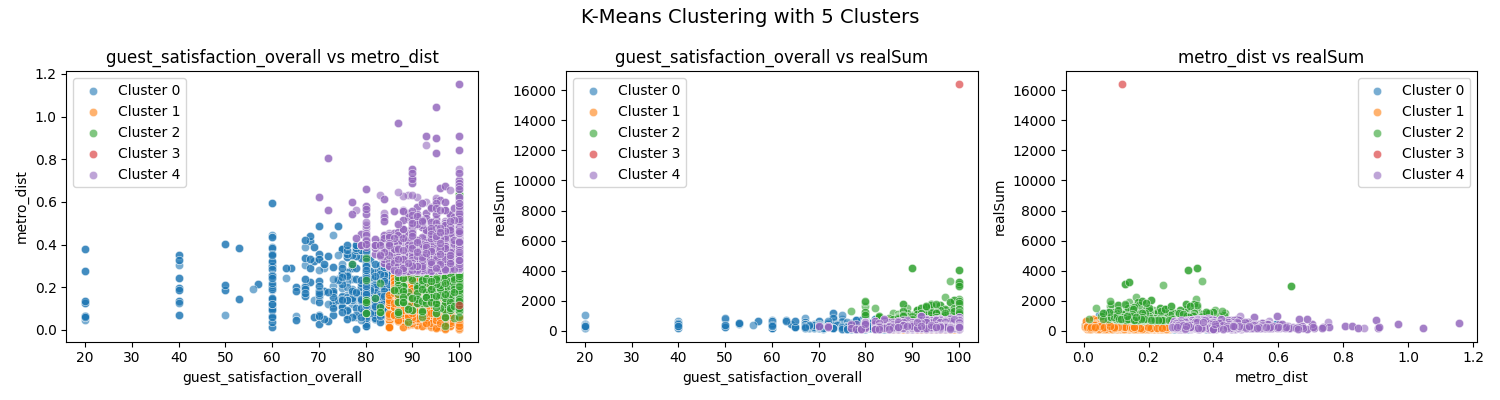

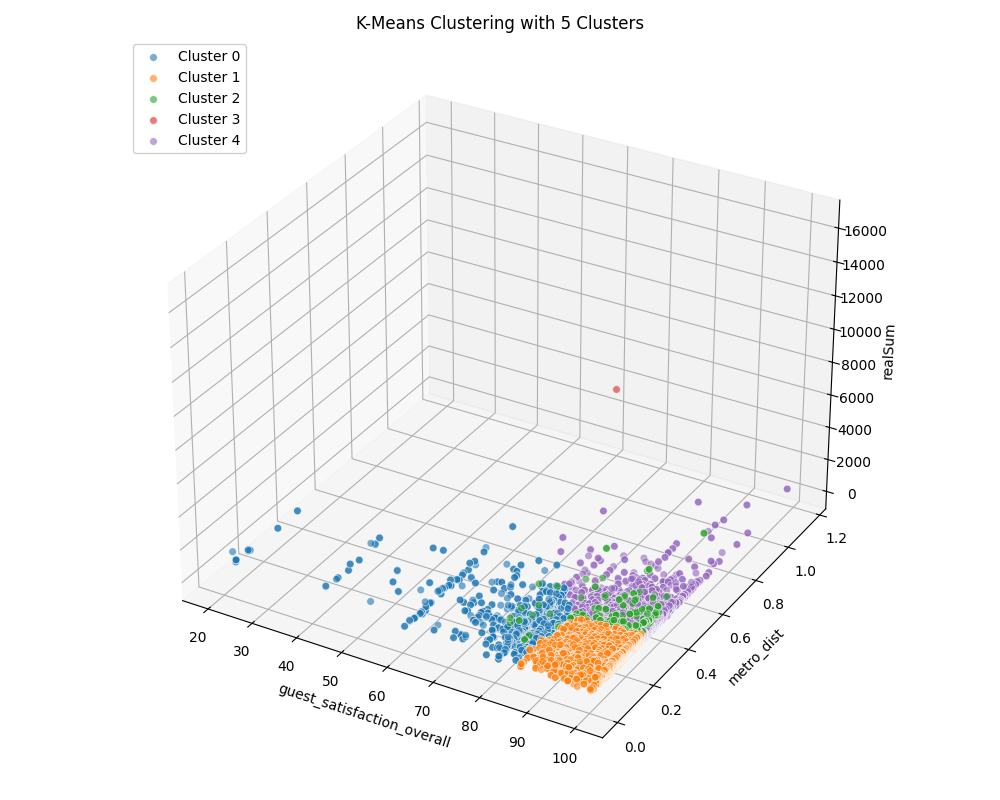

In [19]:
selected_columns = [
    'guest_satisfaction_overall',
    'metro_dist',
    'realSum'
]

cluster_and_draw(paris_all_std, 5, selected_columns)

In [20]:
paris_all_std[paris_all_std["realSum"] > 14000]

,realSum,room_type,room_shared,room_private,person_capacity,host_is_superhost,multi,biz,cleanliness_rating,guest_satisfaction_overall,...,metro_dist,attr_index,attr_index_norm,rest_index,rest_index_norm,lng,lat,is_weekend,cluster_4,cluster_5
2348,16445.614689,Entire home/apt,False,False,2.0,False,0,0,9.0,100.0,...,0.118665,260.896109,12.700335,545.826245,32.072497,2.29772,48.83669,0,3,3
